# Contribution score analysis

This notebook generates plots related to the CNN contribution scores.

Scores were calculated first using the `run_interpretation_in_avg_model.py` and saved to `contributions_ensemble_cnn_model.pickle`.

In [3]:
import json
import os
import pickle
import sys

import numpy
import matplotlib
from matplotlib import pyplot
import pandas
import seaborn

utils_dir = '../utils'
sys.path.append(utils_dir)
import seq_utils
import cnn_vgg
import custom_plots

In [4]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['mathtext.default'] = 'regular'

In [5]:
timepoint_list = [2, 4, 6, 10]

lib_tpm_col = 'TPM_library'
log2_lib_tpm_col = 'log2_TPM_library'

log2_mrl_cols = [f'log2_MRL_{t}hpf' for t in timepoint_list]
delta_log2_x_cols = [f'Δlog2_X_{t}hpf' for t in timepoint_list]

res_log2_mrl_cols = [f'res_log2_MRL_{t}hpf' for t in timepoint_list]
res_delta_log2_x_cols = [f'res_Δlog2_X_{t}hpf' for t in timepoint_list]

log2_x_cols = [f'log2_X_{t}hpf' for t in timepoint_list]

# Predictions
pred_len_cols = [f'pred_len_{c}' for c in log2_mrl_cols + delta_log2_x_cols]
pred_cnn_cols = [f'pred_cnn_ens_{c}' for c in log2_mrl_cols + delta_log2_x_cols]
pred_full_cols = [f'pred_full_{c}' for c in log2_mrl_cols + delta_log2_x_cols]

# Load data

In [6]:
# Load data
data_full = pandas.read_csv(
    '../full_model_evaluation/Zb_5UTR_MPRA_with_preds.tsv',
    index_col=0,
    sep='\t',
)

data_full

,chr,strand,external_gene_name,utr_length,insert_length,n_uORFs,GC_content,mxfold,index,index_base,...,pred_test_log2_MRL_10hpf,pred_full_log2_MRL_10hpf,pred_test_Δlog2_X_2hpf,pred_full_Δlog2_X_2hpf,pred_test_Δlog2_X_4hpf,pred_full_Δlog2_X_4hpf,pred_test_Δlog2_X_6hpf,pred_full_Δlog2_X_6hpf,pred_test_Δlog2_X_10hpf,pred_full_Δlog2_X_10hpf
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,chr9,-,slc35a5,103.0,103.0,2.0,52.427184,23.9,20318.0,20318,...,2.390045,2.553573,-1.719531,-1.708624,-0.710143,-0.665578,-1.793335,-1.837050,-1.989746,-2.020408
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,chr4,-,nrf1,134.0,134.0,0.0,61.940299,35.3,72681.0,72681,...,2.448878,2.415843,-1.891235,-1.980832,-0.591849,-0.552270,-2.007738,-1.982406,-1.125323,-1.193949
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,chr4,+,ube2h,178.0,178.0,1.0,46.629213,30.1,27446.0,27446,...,2.501041,2.379249,-1.884392,-1.935805,-0.474855,-0.408718,-2.229212,-2.221917,-0.678730,-0.704322
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,chr12,+,slc9a3r1a,152.0,152.0,0.0,46.052632,26.1,113092.0,113092,...,2.627780,2.763784,-2.367868,-2.355859,-0.430069,-0.409165,-2.052849,-2.026948,-0.662411,-0.576333
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,chr24,-,dap,153.0,153.0,1.0,47.058824,31.8,20320.0,20320,...,2.482960,2.497563,-2.452622,-2.273506,-0.449078,-0.530098,-2.020428,-2.029758,-1.015012,-0.949125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000060397_ENSDART00000085051_231_hhip_26758.1,chr1,+,hhip,410.0,209.0,2.0,31.578947,26.3,26758.1,26758,...,1.053673,1.320685,-2.363133,-3.065505,-0.596964,-0.732703,-2.512594,-2.252490,-0.694722,-1.061540
ENSDARG00000098284_ENSDART00000170620_10459_ctxn1_29429.4,chr22,+,ctxn1,678.0,174.0,0.0,51.724138,41.2,29429.4,29429,...,2.446544,3.069664,-3.353687,-3.767259,-0.960340,-0.857212,-1.829986,-1.724766,-0.918232,-0.969787
ENSDARG00000103318_ENSDART00000161570_7325_mrpl3_86762,chr19,+,mrpl3,111.0,111.0,2.0,34.234234,12.5,86762.0,86762,...,3.249464,3.248826,-2.183509,-2.343830,-0.353026,-0.293256,-1.775180,-1.836341,-1.560418,-1.601856
ENSDARG00000036698_ENSDART00000053300_7697_znf865_21263.6,chr19,-,znf865,1305.0,197.0,4.0,31.979695,25.9,21263.6,21263,...,2.189054,2.129192,-3.107413,-3.142238,-0.903177,-0.738932,-1.897865,-1.976108,-1.214759,-0.988991


In [7]:
# Preserve only rows with input tpm above threshold
tpm_threshold = 3
data = data_full[data_full[lib_tpm_col] > tpm_threshold]
print(f"{len(data_full):,} total sequences, {len(data):,} retained.")

17,951 total sequences, 17,951 retained.


In [8]:
# Maximum sequence length
max_seq_len = int(data_full['insert_length'].max())

In [9]:
# Load contribution scores
# Dictionary, where keys are insert ids and values are numpy arrays
# with dimensions (n_model_outputs, max_seq_len, 4)

with open('contributions_ensemble_cnn_model.pickle', 'rb') as handle:
    contributions_dict = pickle.load(handle)
# assert set(data.index.to_list()) == set(contributions_dict.keys())
print(f"Contribution scores for {len(contributions_dict)} sequences loaded.")

Contribution scores for 17951 sequences loaded.


# Plot contribution scores and MRL dynamics

## Examples picked for figures

We plot MRL and abundance timecourses and contributions of a few hand-picked examples. We try to plot contributions across the full sequence, and separately on the initiation site context (base -4 and downstream) and a selected region upstream. The initiation site context tends to have high contributions concentrated in a few bases, so it drowns upstream motifs that have lower per-base contribution but comparable motif-wide contributions. Plotting them separately with their own y axis scaling partially solves this issue, but if no actual upstream motifs are present, it may highlight low importance "noise" (spread out contributions without a clear motif).

In [10]:
example_plot_dir = 'contrib_example_plots'
if not os.path.exists(example_plot_dir):
    os.mkdir(example_plot_dir)

In [11]:
def adjust_kozak_ylim(fig1, fig2):
    ylim1 = fig1.get_axes()[1].get_ylim()
    ylim2 = fig2.get_axes()[1].get_ylim()
    c = max(ylim2[1] / ylim1[1], ylim2[0] / ylim1[0])
    ylim2 = (ylim1[0] * c, ylim1[1] * c)
    for ax in fig2.get_axes()[1:]:
        ax.set_ylim(ylim2)

### Higher MRL than expected

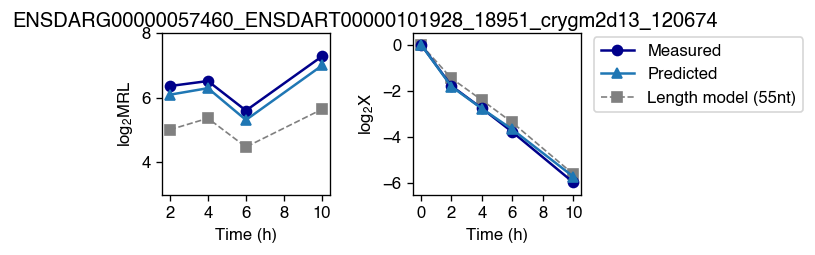

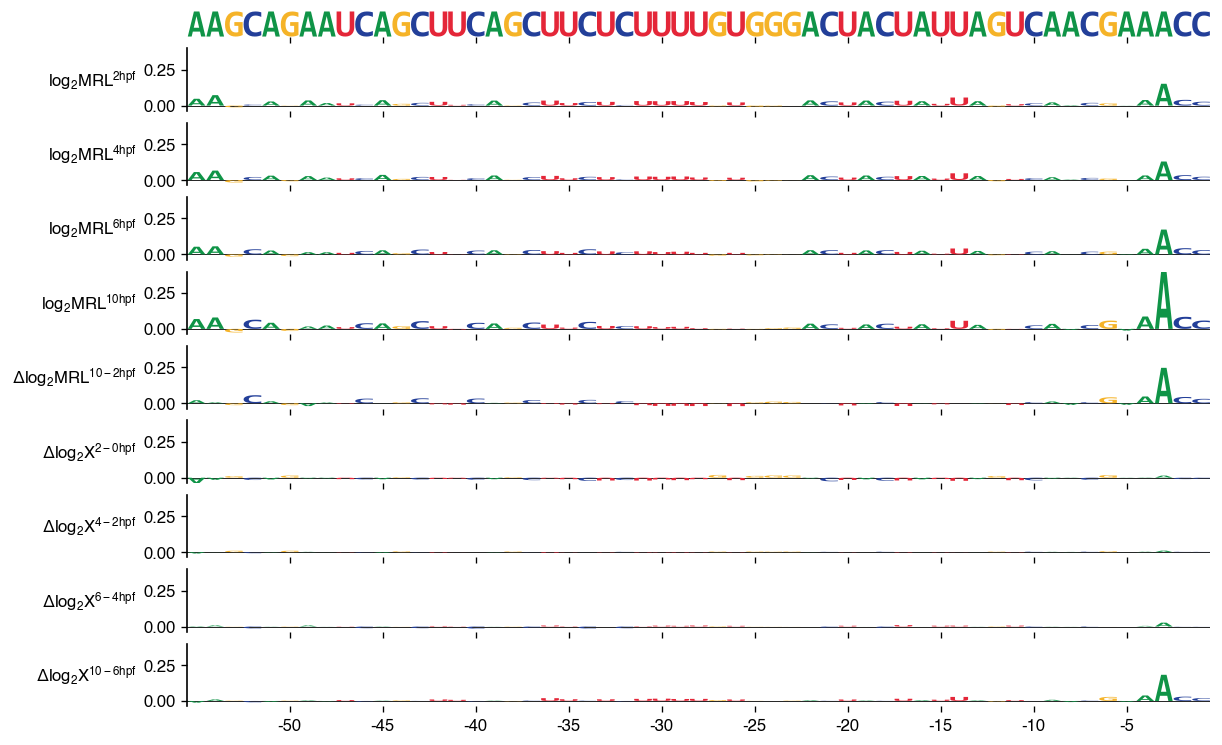

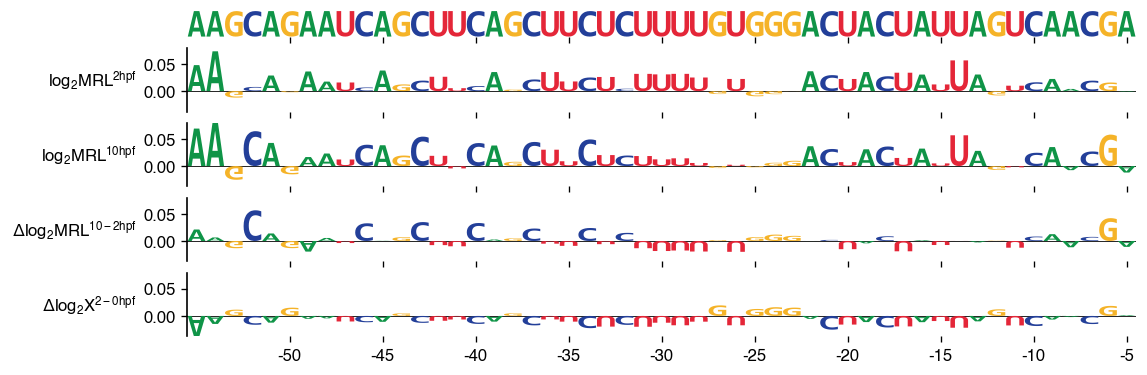

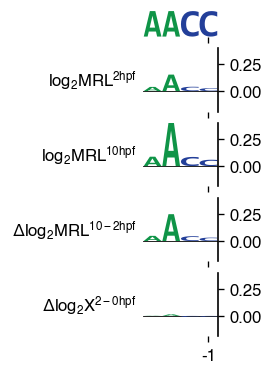

In [18]:
seq_id_to_plot = 'ENSDARG00000057460_ENSDART00000101928_18951_crygm2d13_120674'

fig = custom_plots.plot_single_timecourse(
    data,
    seq_id_to_plot,
    mode='full',
    plot_delta_x=False,
    mrl_timeticks=[2, 4, 6, 8, 10],
    mrl_lim=(3, 8),
    plot_x=True,
    x_lim=(-6.5, 0.5),
    x_timeticks=[0, 2, 4, 6, 8, 10],
    figsize=(4.5, 1.75),
    wspace=0.5,
);
fig.savefig(f'{example_plot_dir}/high_mrl_1_pred_vs_measured.svg')

fig = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    # outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
);
fig.savefig(f'{example_plot_dir}/high_mrl_1_shap.svg')

fig_nonkozak = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['$log_2MRL^{2hpf}$', '$log_2MRL^{10hpf}$', '$Δlog_2MRL^{10-2hpf}$', '$Δlog_2X^{2-0hpf}$'],
    pos=[None, -5],
);

fig_kozak = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['$log_2MRL^{2hpf}$', '$log_2MRL^{10hpf}$', '$Δlog_2MRL^{10-2hpf}$', '$Δlog_2X^{2-0hpf}$'],
    pos=[-4, None],
    ytickpos='right',
);

adjust_kozak_ylim(fig_nonkozak, fig_kozak)
fig_nonkozak.savefig(f'{example_plot_dir}/high_mrl_1_shap_nonkozak.svg')
fig_kozak.savefig(f'{example_plot_dir}/high_mrl_1_shap_kozak.svg')

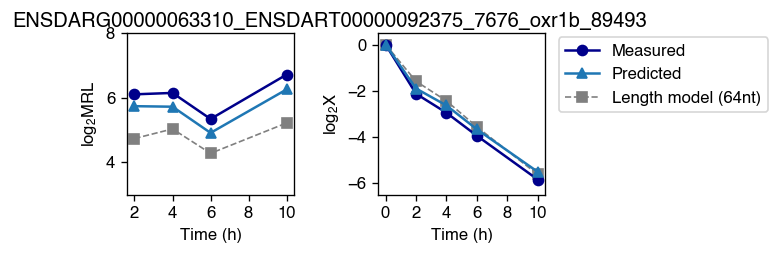

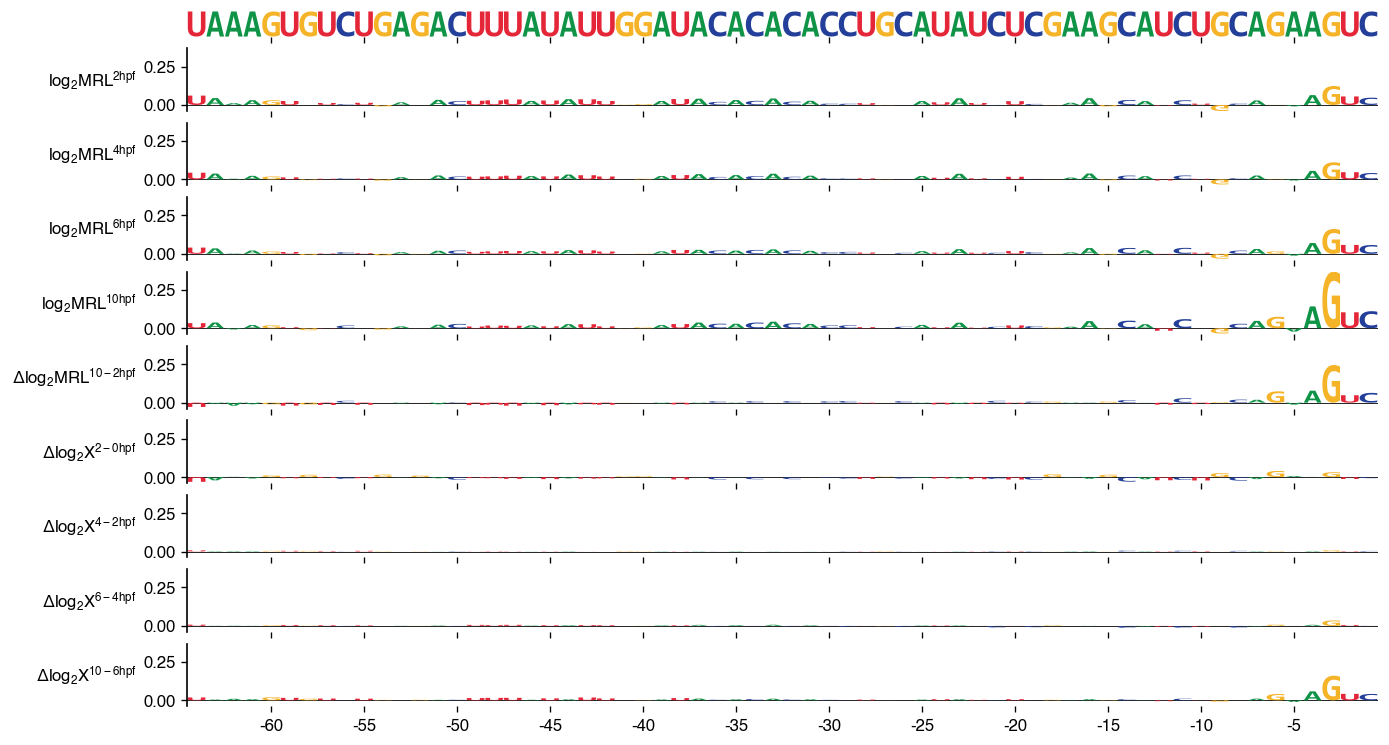

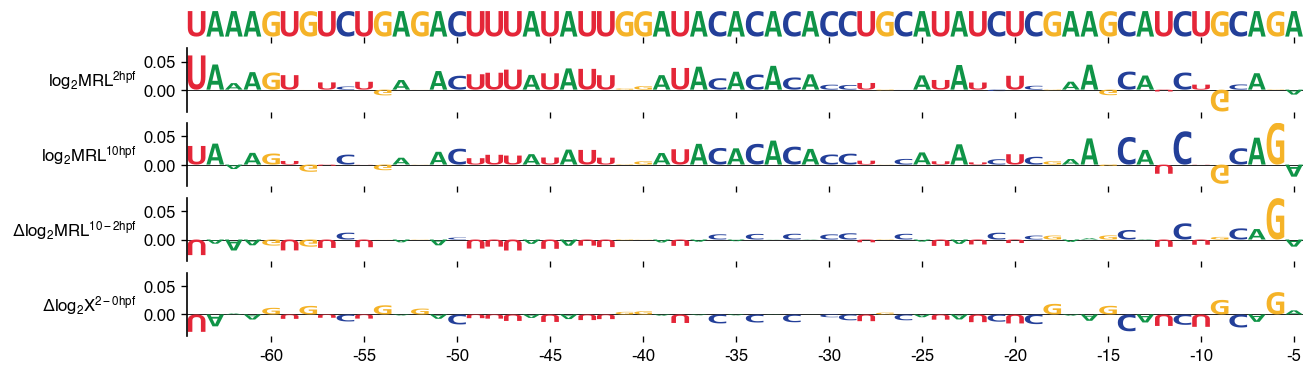

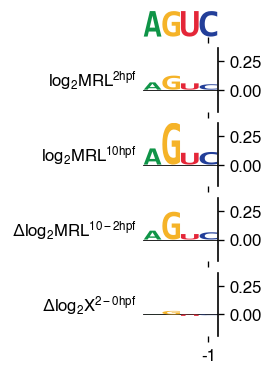

In [19]:
seq_id_to_plot = 'ENSDARG00000063310_ENSDART00000092375_7676_oxr1b_89493'

fig = custom_plots.plot_single_timecourse(
    data,
    seq_id_to_plot,
    mode='full',
    plot_delta_x=False,
    mrl_timeticks=[2, 4, 6, 8, 10],
    mrl_lim=(3, 8),
    plot_x=True,
    x_lim=(-6.5, 0.5),
    x_timeticks=[0, 2, 4, 6, 8, 10],
    figsize=(4.5, 1.75),
    wspace=0.5,
);
fig.savefig(f'{example_plot_dir}/high_mrl_2_pred_vs_measured.svg')

fig = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    # outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    # pos=[-40, None],
);
fig.savefig(f'{example_plot_dir}/high_mrl_2_shap.svg')

fig_nonkozak = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['$log_2MRL^{2hpf}$', '$log_2MRL^{10hpf}$', '$Δlog_2MRL^{10-2hpf}$', '$Δlog_2X^{2-0hpf}$'],
    pos=[None, -5],
);

fig_kozak = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['$log_2MRL^{2hpf}$', '$log_2MRL^{10hpf}$', '$Δlog_2MRL^{10-2hpf}$', '$Δlog_2X^{2-0hpf}$'],
    pos=[-4, None],
    ytickpos='right',
);

adjust_kozak_ylim(fig_nonkozak, fig_kozak)
fig_nonkozak.savefig(f'{example_plot_dir}/high_mrl_2_shap_nonkozak.svg')
fig_kozak.savefig(f'{example_plot_dir}/high_mrl_2_shap_kozak.svg')

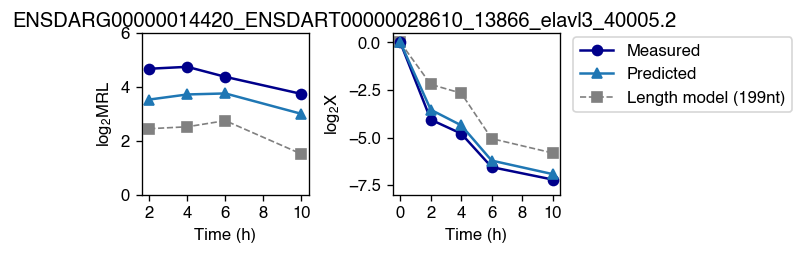

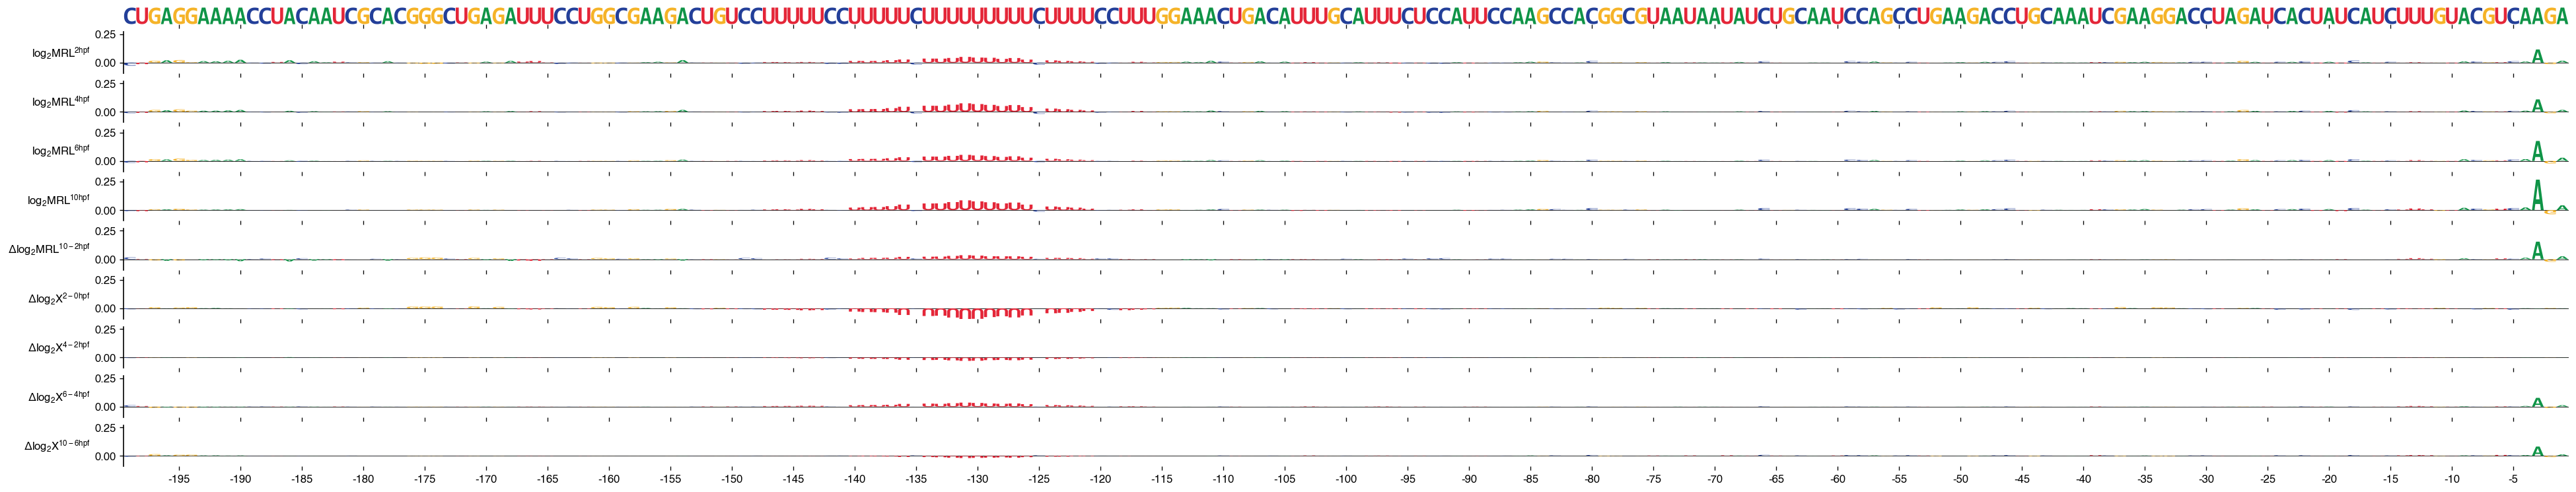

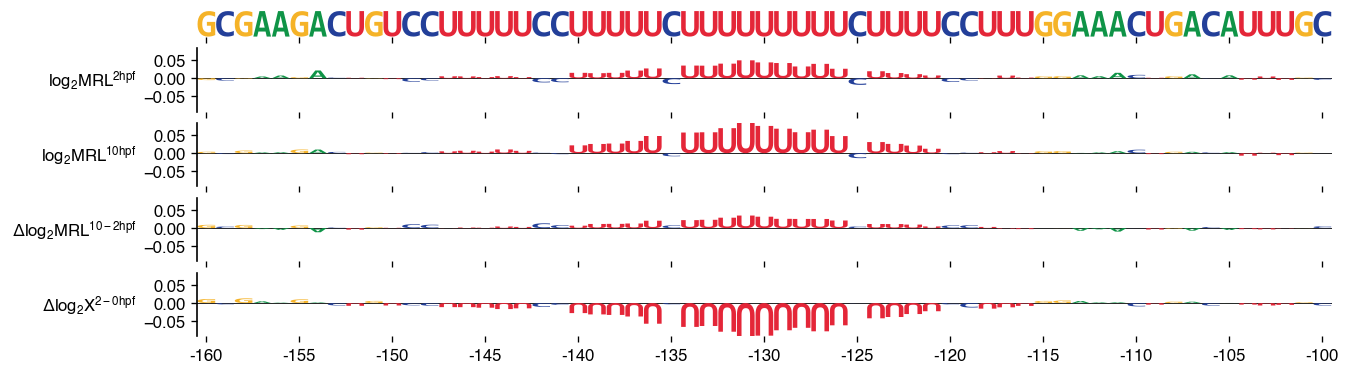

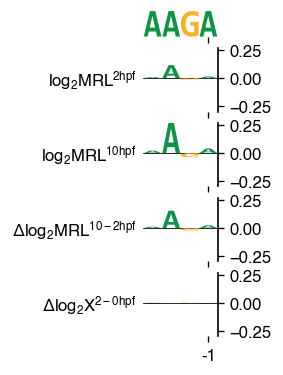

In [30]:
seq_id_to_plot = 'ENSDARG00000014420_ENSDART00000028610_13866_elavl3_40005.2'

fig = custom_plots.plot_single_timecourse(
    data,
    seq_id_to_plot,
    mode='full',
    plot_delta_x=False,
    mrl_timeticks=[2, 4, 6, 8, 10],
    mrl_lim=(0, 6),
    plot_x=True,
    x_lim=(-8, 0.5),
    x_timeticks=[0, 2, 4, 6, 8, 10],
    figsize=(4.5, 1.75),
    wspace=0.5,
);
fig.savefig(f'{example_plot_dir}/high_mrl_3_pred_vs_measured.svg')

fig = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    # outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
);
fig.savefig(f'{example_plot_dir}/high_mrl_3_shap.svg')

fig_nonkozak = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['$log_2MRL^{2hpf}$', '$log_2MRL^{10hpf}$', '$Δlog_2MRL^{10-2hpf}$', '$Δlog_2X^{2-0hpf}$'],
    # pos=[None, -5],
    pos=[-160, -100]
);

fig_kozak = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['$log_2MRL^{2hpf}$', '$log_2MRL^{10hpf}$', '$Δlog_2MRL^{10-2hpf}$', '$Δlog_2X^{2-0hpf}$'],
    pos=[-4, None],
    ytickpos='right',
);

adjust_kozak_ylim(fig_nonkozak, fig_kozak)
fig_nonkozak.savefig(f'{example_plot_dir}/high_mrl_3_shap_nonkozak.svg')
fig_kozak.savefig(f'{example_plot_dir}/high_mrl_3_shap_kozak.svg')

### Lower MRL than expected

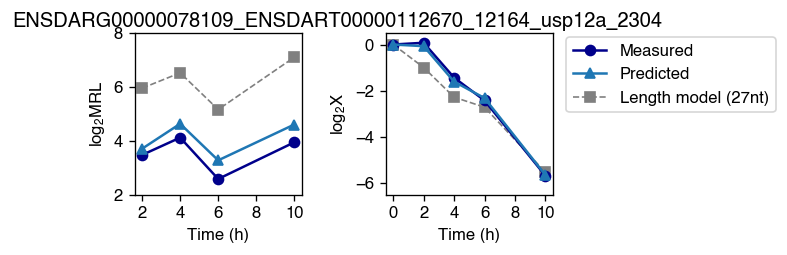

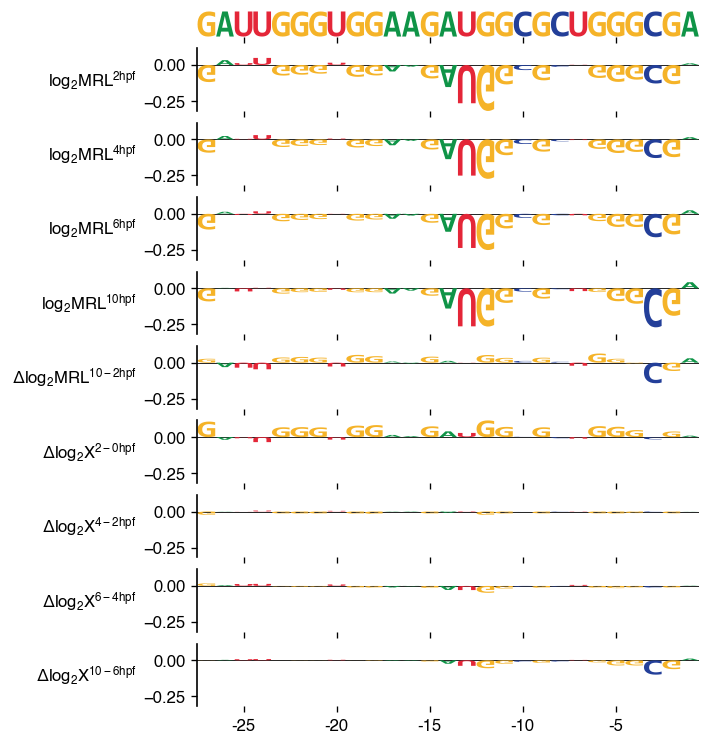

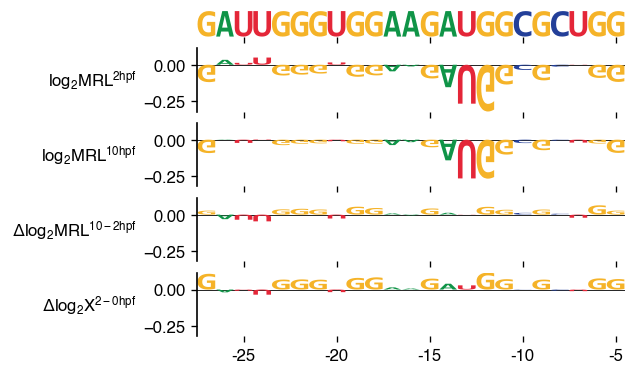

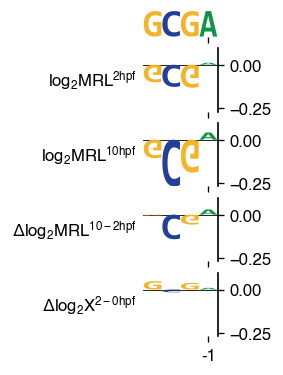

In [21]:
seq_id_to_plot = 'ENSDARG00000078109_ENSDART00000112670_12164_usp12a_2304'

fig = custom_plots.plot_single_timecourse(
    data,
    seq_id_to_plot,
    mode='full',
    plot_delta_x=False,
    mrl_timeticks=[2, 4, 6, 8, 10],
    mrl_lim=(2, 8),
    plot_x=True,
    x_lim=(-6.5, 0.5),
    x_timeticks=[0, 2, 4, 6, 8, 10],
    figsize=(4.5, 1.75),
    wspace=0.5,
);
fig.savefig(f'{example_plot_dir}/low_mrl_1_pred_vs_measured.svg')

fig = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    # outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    # pos=[-40, None],
);
fig.savefig(f'{example_plot_dir}/low_mrl_1_shap.svg')

fig_nonkozak = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['$log_2MRL^{2hpf}$', '$log_2MRL^{10hpf}$', '$Δlog_2MRL^{10-2hpf}$', '$Δlog_2X^{2-0hpf}$'],
    pos=[None, -5],
);

fig_kozak = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['$log_2MRL^{2hpf}$', '$log_2MRL^{10hpf}$', '$Δlog_2MRL^{10-2hpf}$', '$Δlog_2X^{2-0hpf}$'],
    pos=[-4, None],
    ytickpos='right',
);

adjust_kozak_ylim(fig_nonkozak, fig_kozak)
fig_nonkozak.savefig(f'{example_plot_dir}/low_mrl_1_shap_nonkozak.svg')
fig_kozak.savefig(f'{example_plot_dir}/low_mrl_1_shap_kozak.svg')

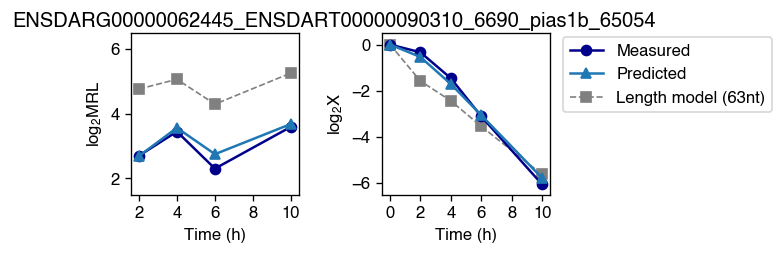

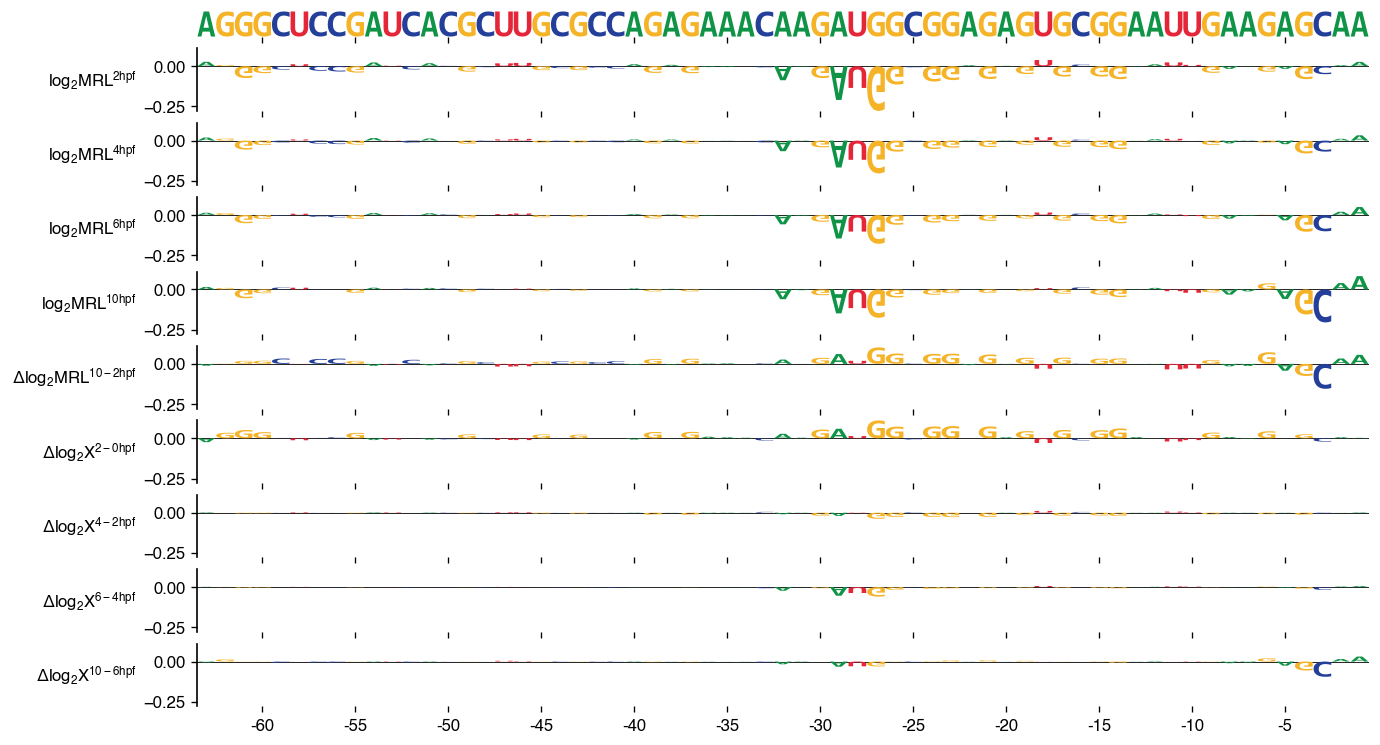

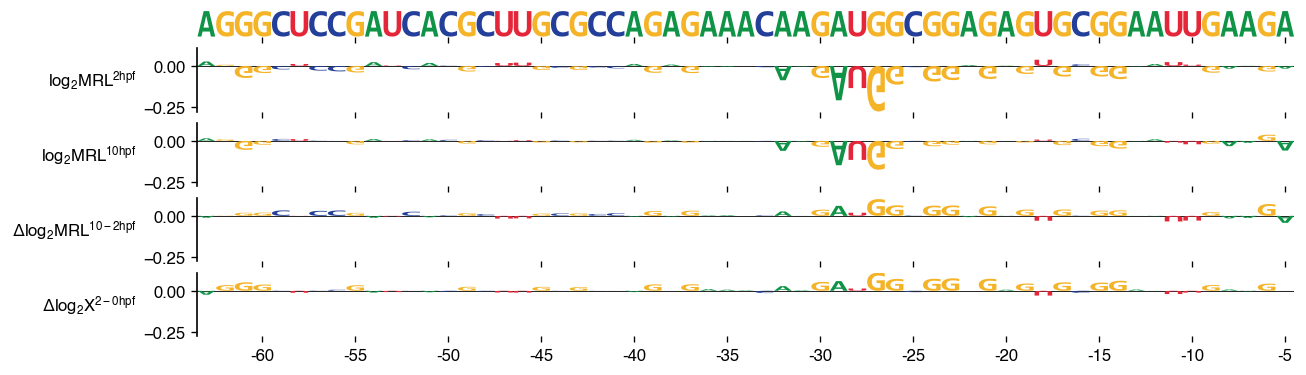

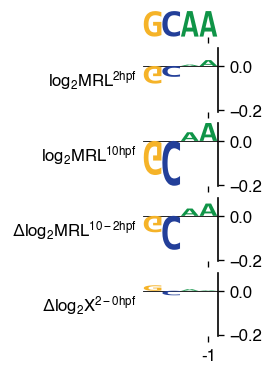

In [22]:
seq_id_to_plot = 'ENSDARG00000062445_ENSDART00000090310_6690_pias1b_65054'

fig = custom_plots.plot_single_timecourse(
    data,
    seq_id_to_plot,
    mode='full',
    plot_delta_x=False,
    mrl_timeticks=[2, 4, 6, 8, 10],
    mrl_lim=(1.5, 6.5),
    plot_x=True,
    x_lim=(-6.5, 0.5),
    x_timeticks=[0, 2, 4, 6, 8, 10],
    figsize=(4.5, 1.75),
    wspace=0.5,
);
fig.savefig(f'{example_plot_dir}/low_mrl_2_pred_vs_measured.svg')

fig = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    # outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    # pos=[-40, None],
);
fig.savefig(f'{example_plot_dir}/low_mrl_2_shap.svg')

fig_nonkozak = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['$log_2MRL^{2hpf}$', '$log_2MRL^{10hpf}$', '$Δlog_2MRL^{10-2hpf}$', '$Δlog_2X^{2-0hpf}$'],
    pos=[None, -5],
);

fig_kozak = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['$log_2MRL^{2hpf}$', '$log_2MRL^{10hpf}$', '$Δlog_2MRL^{10-2hpf}$', '$Δlog_2X^{2-0hpf}$'],
    pos=[-4, None],
    ytickpos='right',
);

adjust_kozak_ylim(fig_nonkozak, fig_kozak)
fig_nonkozak.savefig(f'{example_plot_dir}/low_mrl_2_shap_nonkozak.svg')
fig_kozak.savefig(f'{example_plot_dir}/low_mrl_2_shap_kozak.svg')

### Increasing MRL

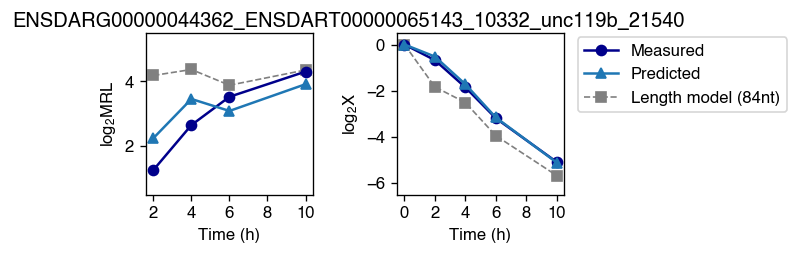

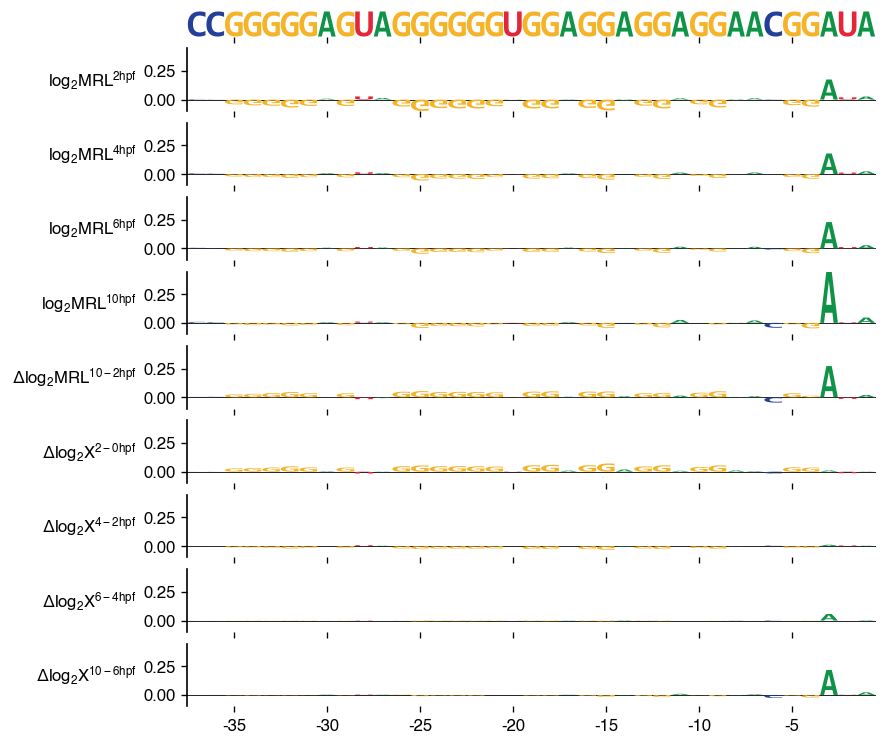

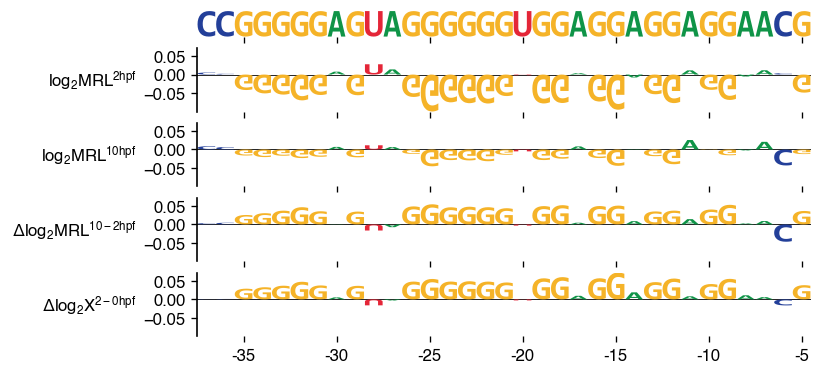

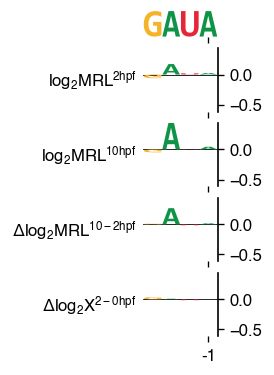

In [23]:
seq_id_to_plot = 'ENSDARG00000044362_ENSDART00000065143_10332_unc119b_21540'

fig = custom_plots.plot_single_timecourse(
    data,
    seq_id_to_plot,
    mode='full',
    plot_delta_x=False,
    mrl_timeticks=[2, 4, 6, 8, 10],
    mrl_lim=(0.5, 5.5),
    plot_x=True,
    x_lim=(-6.5, 0.5),
    x_timeticks=[0, 2, 4, 6, 8, 10],
    figsize=(4.5, 1.75),
    wspace=0.5,
);
fig.savefig(f'{example_plot_dir}/increasing_mrl_main_pred_vs_measured.svg')

fig = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    # outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    pos=[-37, None],
);
fig.savefig(f'{example_plot_dir}/increasing_mrl_main_shap.svg')

fig_nonkozak = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['$log_2MRL^{2hpf}$', '$log_2MRL^{10hpf}$', '$Δlog_2MRL^{10-2hpf}$', '$Δlog_2X^{2-0hpf}$'],
    pos=[-37, -5],
);

fig_kozak = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['$log_2MRL^{2hpf}$', '$log_2MRL^{10hpf}$', '$Δlog_2MRL^{10-2hpf}$', '$Δlog_2X^{2-0hpf}$'],
    pos=[-4, None],
    ytickpos='right',
);

adjust_kozak_ylim(fig_nonkozak, fig_kozak)
fig_nonkozak.savefig(f'{example_plot_dir}/increasing_mrl_main_shap_nonkozak.svg')
fig_kozak.savefig(f'{example_plot_dir}/increasing_mrl_main_shap_kozak.svg')

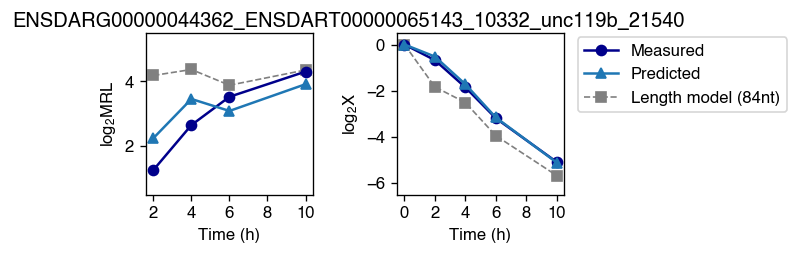

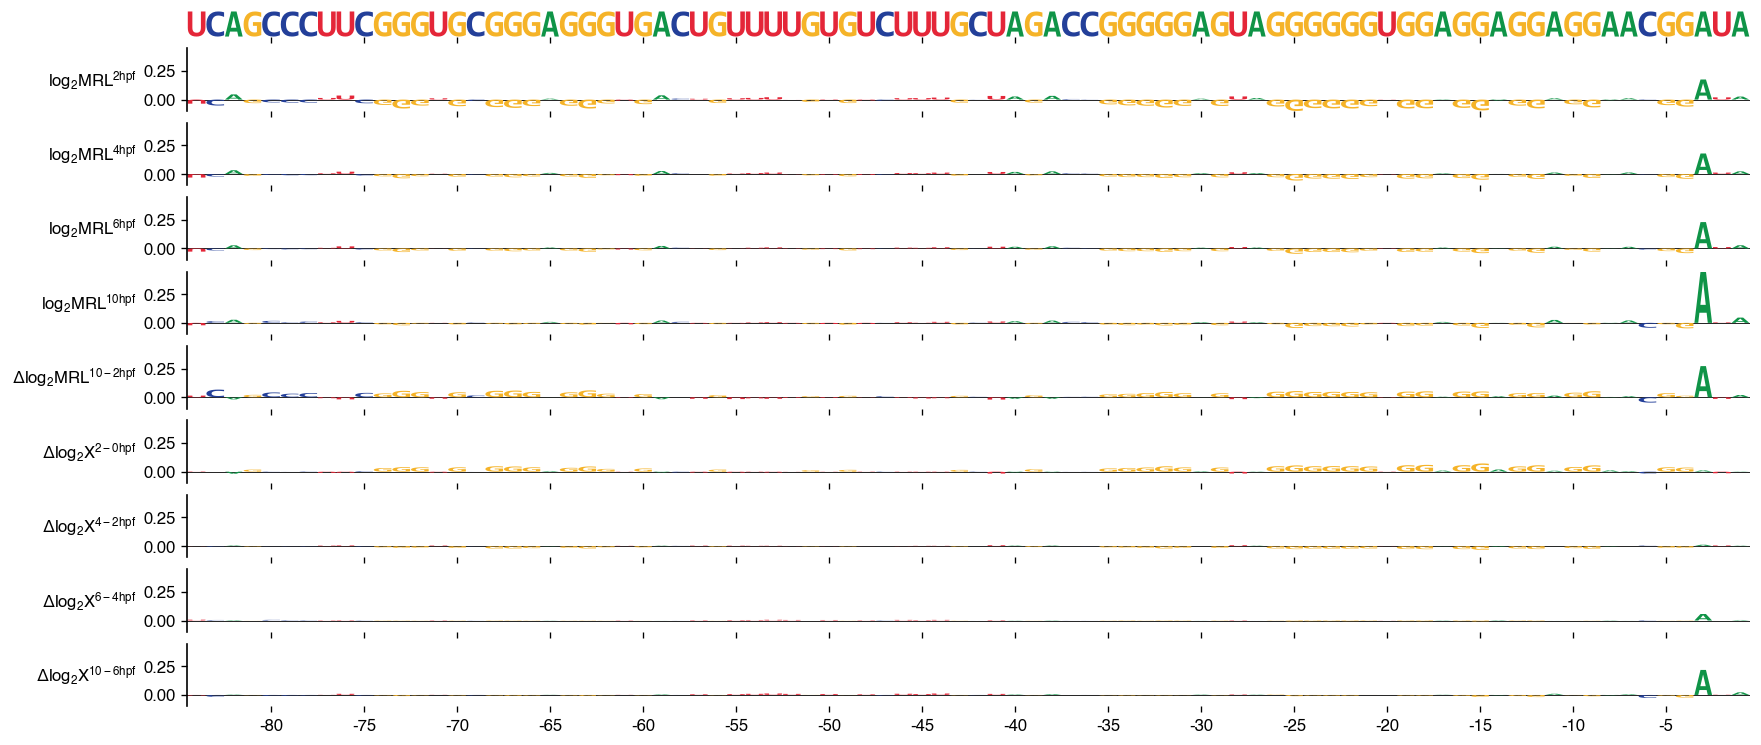

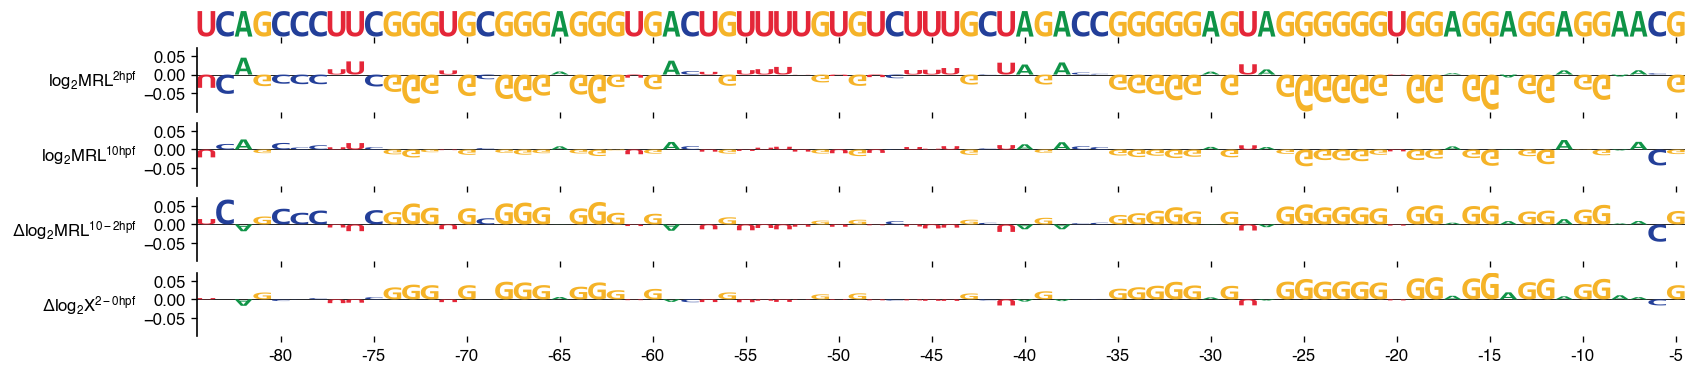

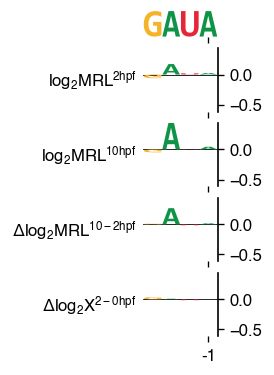

In [24]:
seq_id_to_plot = 'ENSDARG00000044362_ENSDART00000065143_10332_unc119b_21540'

fig = custom_plots.plot_single_timecourse(
    data,
    seq_id_to_plot,
    mode='full',
    plot_delta_x=False,
    mrl_timeticks=[2, 4, 6, 8, 10],
    mrl_lim=(0.5, 5.5),
    plot_x=True,
    x_lim=(-6.5, 0.5),
    x_timeticks=[0, 2, 4, 6, 8, 10],
    figsize=(4.5, 1.75),
    wspace=0.5,
);
fig.savefig(f'{example_plot_dir}/increasing_mrl_1_pred_vs_measured.svg')

fig = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    # outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
);
fig.savefig(f'{example_plot_dir}/increasing_mrl_1_shap.svg')

fig_nonkozak = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['$log_2MRL^{2hpf}$', '$log_2MRL^{10hpf}$', '$Δlog_2MRL^{10-2hpf}$', '$Δlog_2X^{2-0hpf}$'],
    pos=[None, -5],
);

fig_kozak = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['$log_2MRL^{2hpf}$', '$log_2MRL^{10hpf}$', '$Δlog_2MRL^{10-2hpf}$', '$Δlog_2X^{2-0hpf}$'],
    pos=[-4, None],
    ytickpos='right',
);

adjust_kozak_ylim(fig_nonkozak, fig_kozak)
fig_nonkozak.savefig(f'{example_plot_dir}/increasing_mrl_1_shap_nonkozak.svg')
fig_kozak.savefig(f'{example_plot_dir}/increasing_mrl_1_shap_kozak.svg')

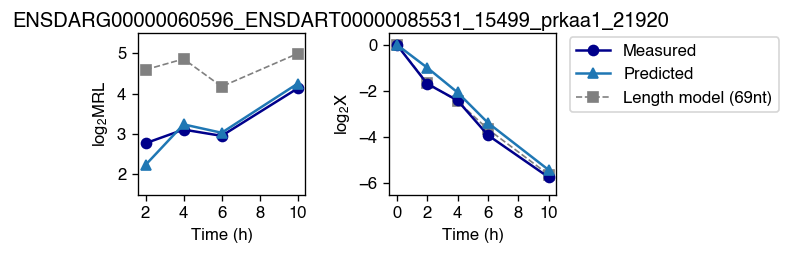

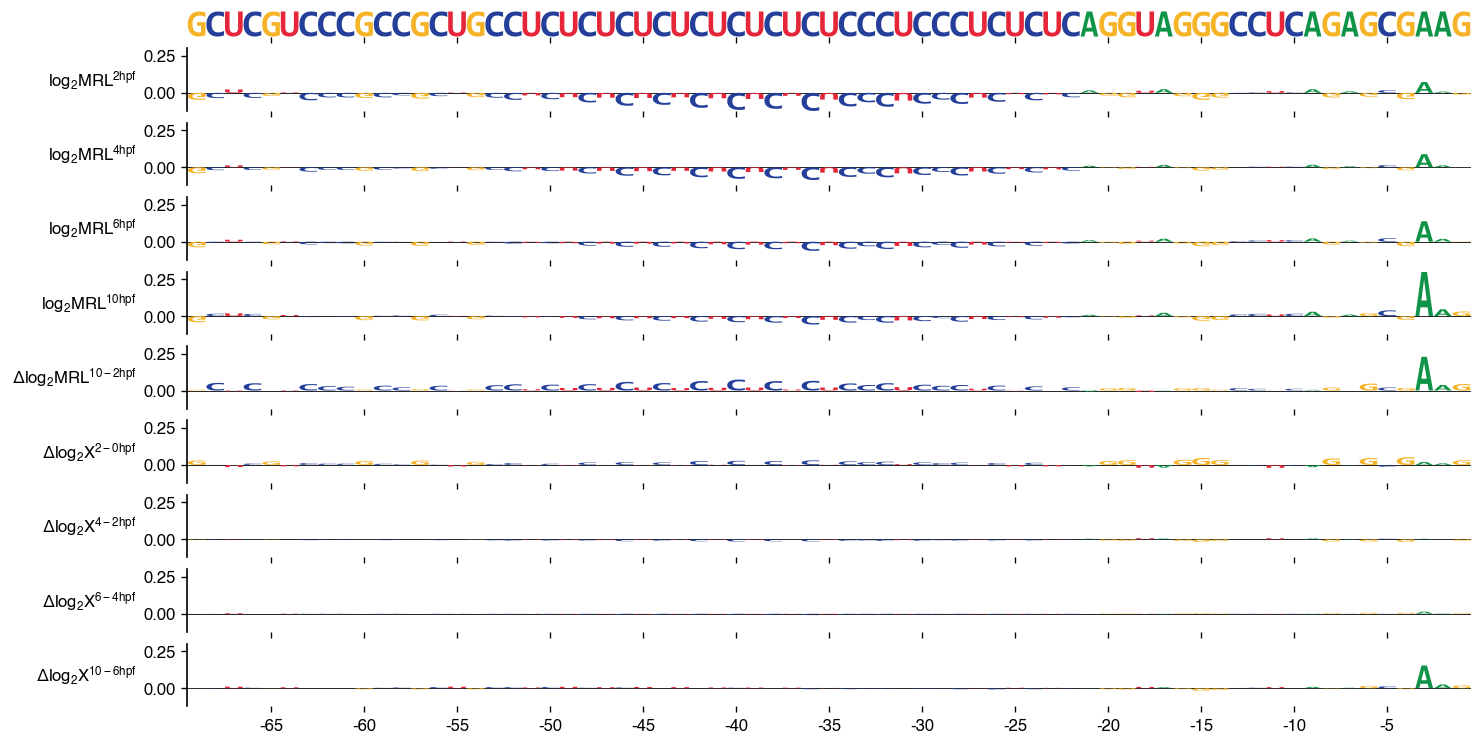

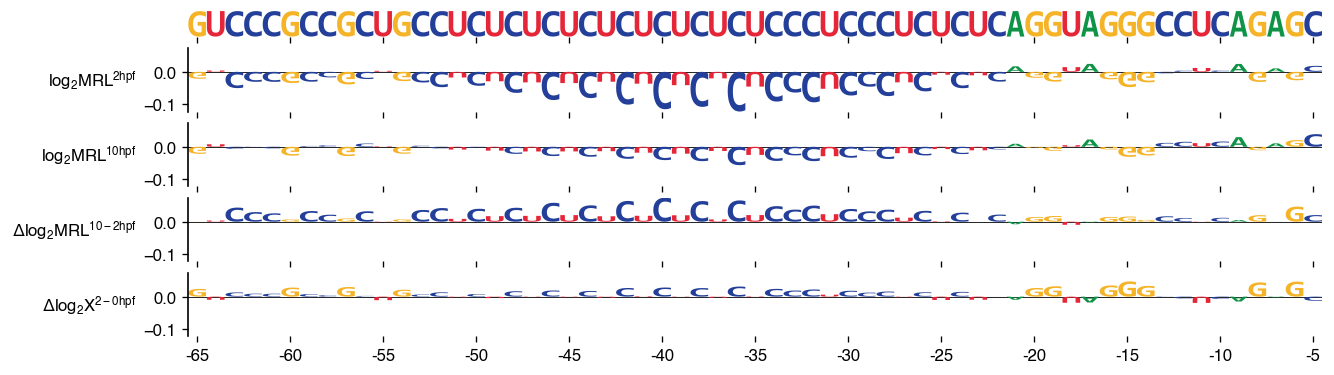

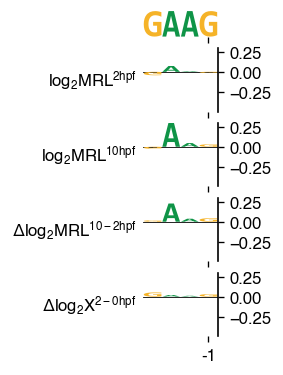

In [31]:
seq_id_to_plot = 'ENSDARG00000060596_ENSDART00000085531_15499_prkaa1_21920'

fig = custom_plots.plot_single_timecourse(
    data,
    seq_id_to_plot,
    mode='full',
    plot_delta_x=False,
    mrl_timeticks=[2, 4, 6, 8, 10],
    mrl_lim=(1.5, 5.5),
    plot_x=True,
    x_lim=(-6.5, 0.5),
    x_timeticks=[0, 2, 4, 6, 8, 10],
    figsize=(4.5, 1.75),
    wspace=0.5,
);
fig.savefig(f'{example_plot_dir}/increasing_mrl_2_pred_vs_measured.svg')

fig = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    # outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    # pos=[-37, None],
);
fig.savefig(f'{example_plot_dir}/increasing_mrl_2_shap.svg')

fig_nonkozak = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['$log_2MRL^{2hpf}$', '$log_2MRL^{10hpf}$', '$Δlog_2MRL^{10-2hpf}$', '$Δlog_2X^{2-0hpf}$'],
    # pos=[None, -5],
    pos=[-65, -5]
);

fig_kozak = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['$log_2MRL^{2hpf}$', '$log_2MRL^{10hpf}$', '$Δlog_2MRL^{10-2hpf}$', '$Δlog_2X^{2-0hpf}$'],
    pos=[-4, None],
    ytickpos='right',
);

adjust_kozak_ylim(fig_nonkozak, fig_kozak)
fig_nonkozak.savefig(f'{example_plot_dir}/increasing_mrl_2_shap_nonkozak.svg')
fig_kozak.savefig(f'{example_plot_dir}/increasing_mrl_2_shap_kozak.svg')

### Decreasing MRL

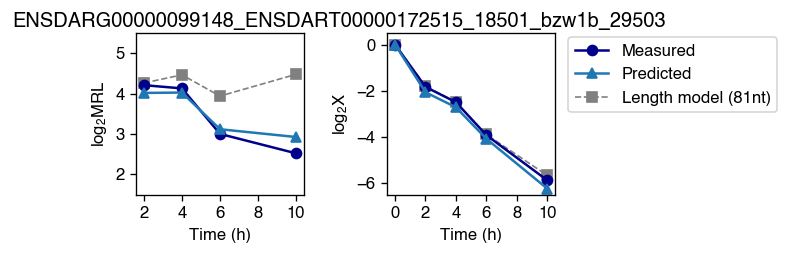

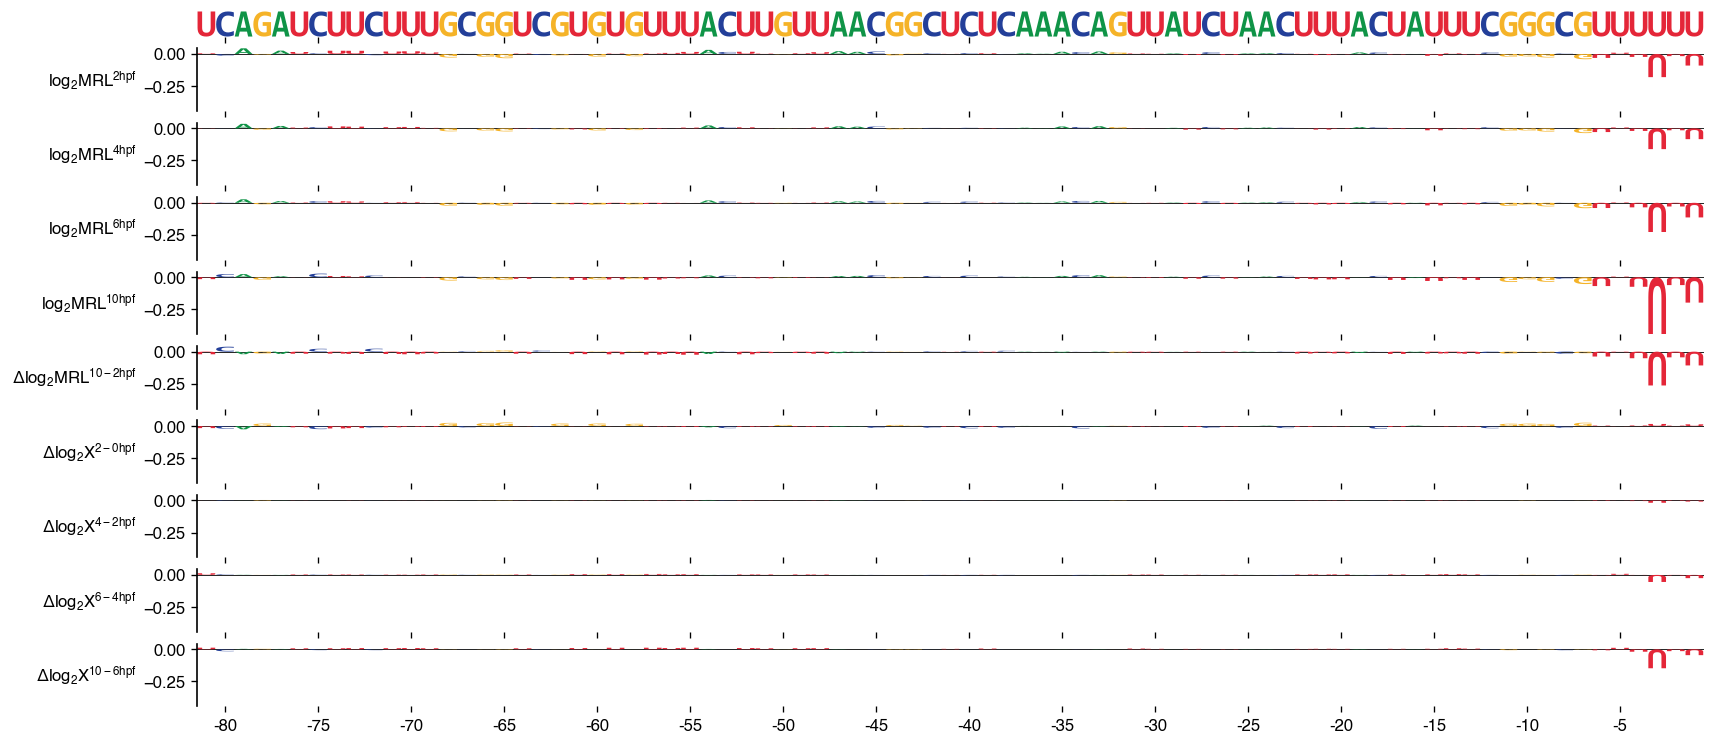

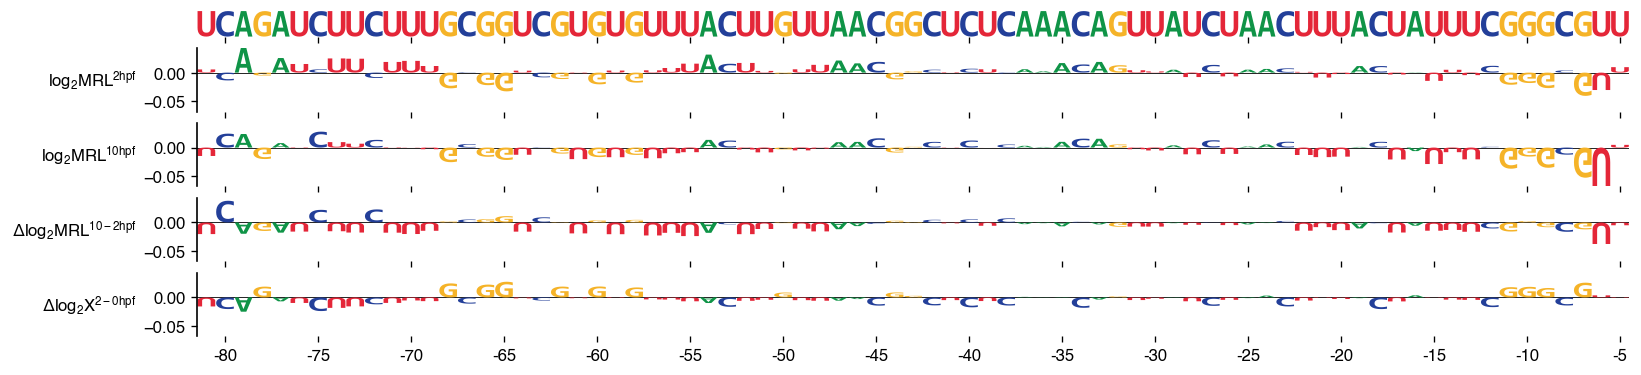

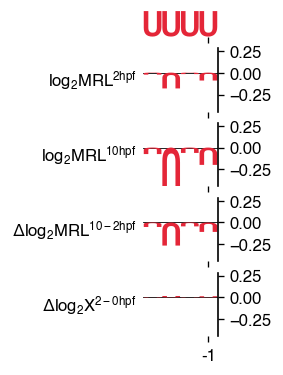

In [26]:
seq_id_to_plot = 'ENSDARG00000099148_ENSDART00000172515_18501_bzw1b_29503'

fig = custom_plots.plot_single_timecourse(
    data,
    seq_id_to_plot,
    mode='full',
    plot_delta_x=False,
    mrl_timeticks=[2, 4, 6, 8, 10],
    mrl_lim=(1.5, 5.5),
    plot_x=True,
    x_lim=(-6.5, 0.5),
    x_timeticks=[0, 2, 4, 6, 8, 10],
    figsize=(4.5, 1.75),
    wspace=0.5,
);
fig.savefig(f'{example_plot_dir}/decreasing_mrl_1_pred_vs_measured.svg')

fig = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    # outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    # pos=[-40, None],
);
fig.savefig(f'{example_plot_dir}/decreasing_mrl_1_shap.svg')

fig_nonkozak = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['$log_2MRL^{2hpf}$', '$log_2MRL^{10hpf}$', '$Δlog_2MRL^{10-2hpf}$', '$Δlog_2X^{2-0hpf}$'],
    pos=[None, -5],
);

fig_kozak = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['$log_2MRL^{2hpf}$', '$log_2MRL^{10hpf}$', '$Δlog_2MRL^{10-2hpf}$', '$Δlog_2X^{2-0hpf}$'],
    pos=[-4, None],
    ytickpos='right',
);

adjust_kozak_ylim(fig_nonkozak, fig_kozak)
fig_nonkozak.savefig(f'{example_plot_dir}/decreasing_mrl_1_shap_nonkozak.svg')
fig_kozak.savefig(f'{example_plot_dir}/decreasing_mrl_1_shap_kozak.svg')

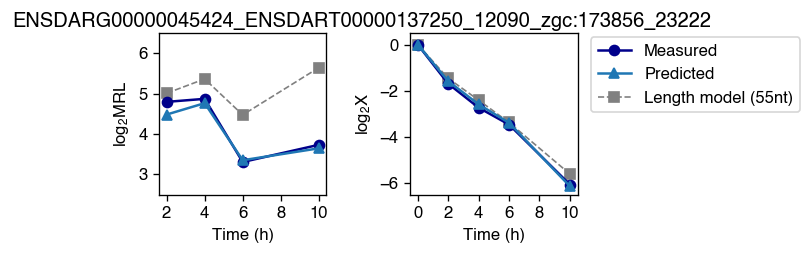

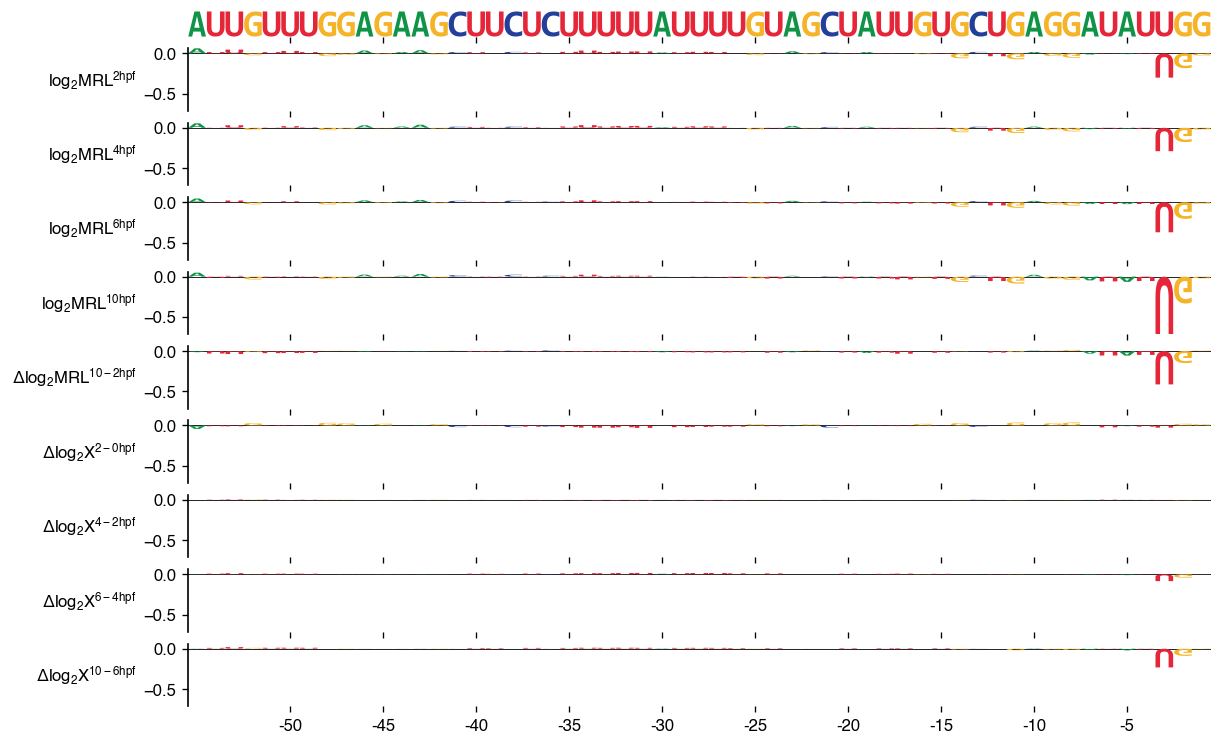

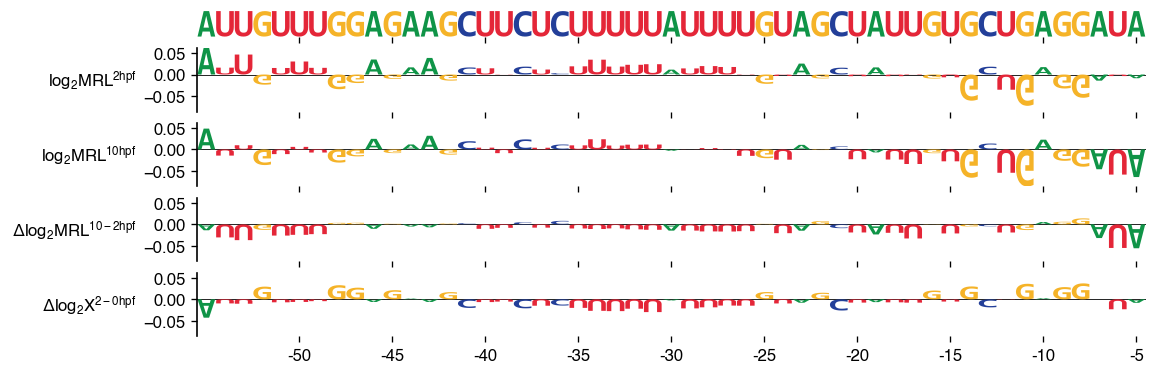

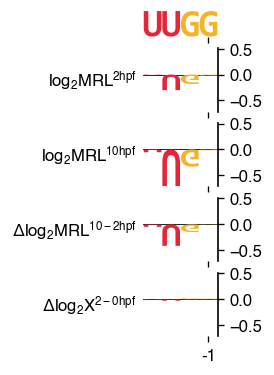

In [27]:
seq_id_to_plot = 'ENSDARG00000045424_ENSDART00000137250_12090_zgc:173856_23222'

fig = custom_plots.plot_single_timecourse(
    data,
    seq_id_to_plot,
    mode='full',
    plot_delta_x=False,
    mrl_timeticks=[2, 4, 6, 8, 10],
    mrl_lim=(2.5, 6.5),
    plot_x=True,
    x_lim=(-6.5, 0.5),
    x_timeticks=[0, 2, 4, 6, 8, 10],
    figsize=(4.5, 1.75),
    wspace=0.5,
);
fig.savefig(f'{example_plot_dir}/decreasing_mrl_2_pred_vs_measured.svg')

fig = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    # outputs_to_plot=['log2_MRL_2hpf', 'log2_MRL_10hpf', 'Δlog2_MRL_10-2hpf'],
    # pos=[-40, None],
);
fig.savefig(f'{example_plot_dir}/decreasing_mrl_2_shap.svg')

fig_nonkozak = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['$log_2MRL^{2hpf}$', '$log_2MRL^{10hpf}$', '$Δlog_2MRL^{10-2hpf}$', '$Δlog_2X^{2-0hpf}$'],
    pos=[None, -5],
);

fig_kozak = custom_plots.plot_contribution_scores(
    data,
    contributions_dict,
    seq_id_to_plot,
    outputs_to_plot=['$log_2MRL^{2hpf}$', '$log_2MRL^{10hpf}$', '$Δlog_2MRL^{10-2hpf}$', '$Δlog_2X^{2-0hpf}$'],
    pos=[-4, None],
    ytickpos='right',
);

adjust_kozak_ylim(fig_nonkozak, fig_kozak)
fig_nonkozak.savefig(f'{example_plot_dir}/decreasing_mrl_2_shap_nonkozak.svg')
fig_kozak.savefig(f'{example_plot_dir}/decreasing_mrl_2_shap_kozak.svg')

# Global trends in contributions

In [20]:
# Get all projected contribution scores in a single array
# Dimensions are n_model_outputs, n_seqs, max_seq_len
seqs_one_hot = seq_utils.one_hot_encode(
    data['insert_seq'].values,
    max_seq_len=max_seq_len,
    padding='right',
    mask_val=0,
)
all_shap_scores = numpy.zeros((len(log2_mrl_cols + delta_log2_x_cols), len(data), seqs_one_hot.shape[1]))

for row_idx, (seq_id, row) in enumerate(data.iterrows()):
    # Sequence
    seq_one_hot = seqs_one_hot[row_idx]
    # Shap scores
    # Dimensions are (n_outputs, max_seq_len, 4)
    shap_scores = contributions_dict[seq_id]

    for model_output_idx, model_output in enumerate(log2_mrl_cols + delta_log2_x_cols):
        # Project using one-hot sequnce
        # Dimensions are (1, max_seq_len, 4)
        scores_projected = shap_scores[model_output_idx][None,:,:]*seq_one_hot
        # Dimensions are max_seq_len
        scores_projected = numpy.sum(scores_projected[0], axis=-1)
        # Fill zero-padding with numpy.nan
        scores_projected[:-int(row['insert_length'])] = numpy.nan

        # Accumulate
        all_shap_scores[model_output_idx, row_idx, :] = scores_projected


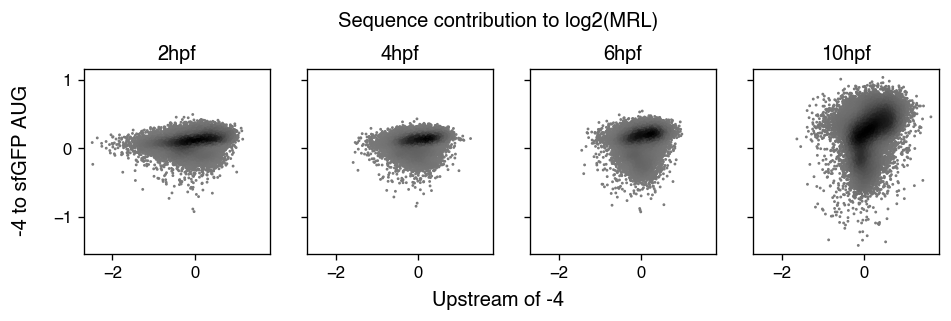

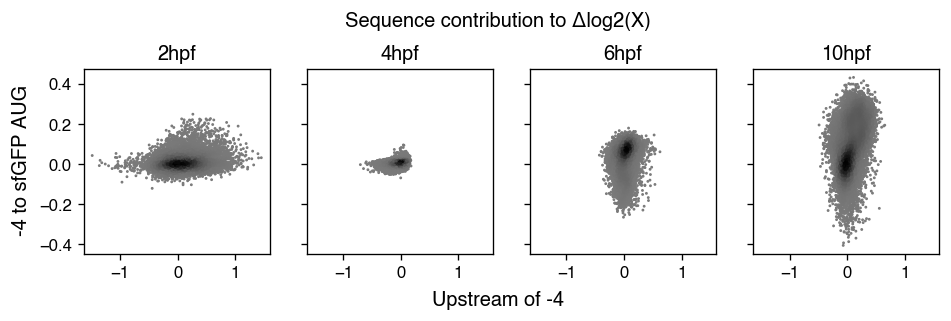

In [21]:
# Proportion of scores before/after specified position
pos_thresh = -4
shap_score_before_thresh = numpy.nansum(all_shap_scores[:, :, :pos_thresh], axis=-1)
shap_score_after_thresh = numpy.nansum(all_shap_scores[:, :, pos_thresh:], axis=-1)

# MRL cols
fig, axes = pyplot.subplots(
    1,
    len(log2_mrl_cols),
    figsize=(2.3*len(log2_mrl_cols), 2),
    sharex=True,
    sharey=True,
)
for model_output_idx, model_output in enumerate(log2_mrl_cols):
    ax = axes[model_output_idx]
    custom_plots.plot_scatter_shaded(
        x=shap_score_before_thresh[model_output_idx],
        y=shap_score_after_thresh[model_output_idx],
        ax=ax,
    )
    ax.set_title(f'{timepoint_list[model_output_idx]}hpf')

fig.suptitle('Sequence contribution to log2(MRL)', y=1.12)
fig.supxlabel(f"Upstream of {pos_thresh}", y=-0.12)
fig.supylabel(f'{pos_thresh} to sfGFP AUG', x=0.06,)
fig.savefig('sum_scores_by_pos_mrl.svg')

# FC cols
fig, axes = pyplot.subplots(
    1,
    len(delta_log2_x_cols),
    figsize=(2.3*len(delta_log2_x_cols), 2),
    sharex=True,
    sharey=True,
)
for model_output_idx, model_output in enumerate(delta_log2_x_cols):
    ax = axes[model_output_idx]
    custom_plots.plot_scatter_shaded(
        x=shap_score_before_thresh[len(log2_mrl_cols) + model_output_idx],
        y=shap_score_after_thresh[len(log2_mrl_cols) + model_output_idx],
        ax=ax,
    )
    ax.set_title(f'{timepoint_list[model_output_idx]}hpf')

fig.suptitle('Sequence contribution to Δlog2(X)', y=1.12)
fig.supxlabel(f"Upstream of {pos_thresh}", y=-0.12)
fig.supylabel(f'{pos_thresh} to sfGFP AUG', x=0.06,)
fig.savefig('sum_scores_by_pos_delta_log2_X.svg')

# Switching examples

In [12]:
switching_plot_dir = 'switching_plots'
if not os.path.exists(switching_plot_dir):
    os.mkdir(switching_plot_dir)

In [13]:
# info about switching pairs to plot
switching_pairs = [
    {
        'name': 'jpt2',
        'seq_id_pre': 'ENSDARG00000034427_ENSDART00000055780_13012_jpt2_26174',
        'seq_id_post': 'ENSDARG00000034427_ENSDART00000055780_13012_jpt2_4385',
    },
    {
        'name': 'scarb2c',
        'seq_id_pre': 'ENSDARG00000089844_ENSDART00000130648_9696_scarb2c_315',
        'seq_id_post': 'ENSDARG00000089844_ENSDART00000130648_9696_scarb2c_138265',
    },
    {
        'name': 'ube2q2',
        'seq_id_pre': 'ENSDARG00000013990_ENSDART00000124645_12840_ube2q2_22659',
        'seq_id_post': 'ENSDARG00000013990_ENSDART00000124645_12840_ube2q2_2339',
    },
    
    {
        'name': 'zzz3',
        'seq_id_pre': 'ENSDARG00000077581_ENSDART00000134308_8074_zzz3_27788',
        'seq_id_post': 'ENSDARG00000077581_ENSDART00000134308_8074_zzz3_4616',
    },
    {
        'name': 'gpr155a',
        'seq_id_pre': 'ENSDARG00000090804_ENSDART00000147034_18520_gpr155a_28438',
        'seq_id_post': 'ENSDARG00000090804_ENSDART00000147034_18520_gpr155a_13539',
        'label_pre': 'ZGA',
        'label_post': 'PostZGA',
    },
    {
        'name': 'CU694202.1',
        'seq_id_pre': 'ENSDARG00000097014_ENSDART00000156841_18455_CU694202.1_12924',
        'seq_id_post': 'ENSDARG00000097014_ENSDART00000156841_18455_CU694202.1_122913',
        'label_pre': 'ZGA',
        'label_post': 'PostZGA',
    },
    {
        'name': 'cfl1l',
        'seq_id_pre': 'ENSDARG00000012972_ENSDART00000026464_3113_cfl1l_25720',
        'seq_id_post': 'ENSDARG00000012972_ENSDART00000026464_3113_cfl1l_1428',
    },
    {
        'name': 'jam2a',
        'seq_id_pre': 'ENSDARG00000058996_ENSDART00000135944_24_jam2a_338',
        'seq_id_post': 'ENSDARG00000058996_ENSDART00000135944_24_jam2a_1698',
    },
    {
        'name': 'ints1',
        'seq_id_pre': 'ENSDARG00000100419_ENSDART00000163595_13330_ints1_67304',
        'seq_id_post': 'ENSDARG00000100419_ENSDART00000163595_13330_ints1_13639',
        'label_pre': 'ZGA',
        'label_post': 'PostZGA',
    },
]

In [14]:
for switching_pair_idx, switching_pair in enumerate(switching_pairs):
    print(f"Generating plots for gene {switching_pair['name']} ({switching_pair_idx + 1} / {len(switching_pairs)})...")

    if 'label_pre' not in switching_pair:
        switching_pair['label_pre'] = 'Maternal'
    if 'label_post' not in switching_pair:
        switching_pair['label_post'] = 'Zygotic'

    # MRL over time
    mrl_savefig = os.path.join(switching_plot_dir, f"{switching_pair['name']}_mrl")
    fig = custom_plots.plot_switching_timecourse(
        data,
        pre_seq_id=switching_pair['seq_id_pre'],
        post_seq_id=switching_pair['seq_id_post'],
        pre_label=switching_pair['label_pre'],
        post_label=switching_pair['label_post'],
        mode='full',
        # plot_random=False,
        plot_delta_x=False,
        title=switching_pair['name'],
        mrl_timeticks=[2, 4, 6, 8, 10],
        # mrl_ylim=(0, 4),
        mrl_lim='auto',
        figsize=(3, 3),
        savefig=mrl_savefig + '.png',
    )
    ylim = fig.axes[0].get_ylim()
    fig.axes[0].set_ylim(ylim[0] - 0.5, ylim[1] + 0.5)
    fig.savefig(mrl_savefig + '.png', dpi=200, bbox_inches='tight')
    fig.savefig(mrl_savefig + '.pdf', dpi=200, bbox_inches='tight')

    # SHAP score, pre
    shap_mat_savefig = os.path.join(switching_plot_dir, f"{switching_pair['name']}_shap_{switching_pair['label_pre'].lower()}")
    fig = custom_plots.plot_contribution_scores(
        data,
        contributions_dict=contributions_dict,
        seq_id_to_plot=switching_pair['seq_id_pre'],
        outputs_to_plot=['$log_2MRL^{2hpf}$', '$log_2MRL^{10hpf}$', '$Δlog_2MRL^{10-2hpf}$', '$Δlog_2X^{2-0hpf}$'],
        savefig=shap_mat_savefig + '.png',
    );
    fig.suptitle(switching_pair['name'] + ', ' + switching_pair['label_pre'])
    fig.savefig(shap_mat_savefig + '.png', dpi=200, bbox_inches='tight')
    fig.savefig(shap_mat_savefig + '.pdf', dpi=200, bbox_inches='tight')

    # SHAP score, post
    shap_zyg_savefig = os.path.join(switching_plot_dir, f"{switching_pair['name']}_shap_{switching_pair['label_post'].lower()}")
    fig = custom_plots.plot_contribution_scores(
        data,
        contributions_dict=contributions_dict,
        seq_id_to_plot=switching_pair['seq_id_post'],
        outputs_to_plot=['$log_2MRL^{2hpf}$', '$log_2MRL^{10hpf}$', '$Δlog_2MRL^{10-2hpf}$', '$Δlog_2X^{2-0hpf}$'],
        savefig=shap_zyg_savefig + '.png',
    );
    fig.suptitle(switching_pair['name'] + ', ' + switching_pair['label_post'])
    fig.savefig(shap_zyg_savefig + '.png', dpi=200, bbox_inches='tight')
    fig.savefig(shap_zyg_savefig + '.pdf', dpi=200, bbox_inches='tight')

    # SHAP scores, additional sequence
    shap_delta_savefig = os.path.join(switching_plot_dir, f"{switching_pair['name']}_shap_delta")
    if data.loc[switching_pair['seq_id_pre'], 'insert_length'] > data.loc[switching_pair['seq_id_post'], 'insert_length']:
        seq_id_to_plot = switching_pair['seq_id_pre']
        end_pos = - int(data.loc[switching_pair['seq_id_post'], 'insert_length'])
        title_suffix = switching_pair['label_pre'] + ' - ' + switching_pair['label_post']
    else:
        seq_id_to_plot = switching_pair['seq_id_post']
        end_pos = - int(data.loc[switching_pair['seq_id_pre'], 'insert_length'])
        title_suffix = switching_pair['label_post'] + ' - ' + switching_pair['label_pre']

    fig = custom_plots.plot_contribution_scores(
        data,
        contributions_dict=contributions_dict,
        seq_id_to_plot=seq_id_to_plot,
        outputs_to_plot=['$log_2MRL^{2hpf}$', '$log_2MRL^{10hpf}$', '$Δlog_2MRL^{10-2hpf}$', '$Δlog_2X^{2-0hpf}$'],
        pos=[None, end_pos],
        savefig=shap_delta_savefig + '.png',
    );
    fig.suptitle(switching_pair['name'] + ', ' + title_suffix)
    fig.savefig(shap_delta_savefig + '.png', dpi=200, bbox_inches='tight')
    fig.savefig(shap_delta_savefig + '.pdf', dpi=200, bbox_inches='tight')

pyplot.close(fig)

Generating plots for gene jpt2 (1 / 9)...
Generating plots for gene scarb2c (2 / 9)...
Generating plots for gene ube2q2 (3 / 9)...
Generating plots for gene zzz3 (4 / 9)...
Generating plots for gene gpr155a (5 / 9)...
Generating plots for gene CU694202.1 (6 / 9)...
Generating plots for gene cfl1l (7 / 9)...
Generating plots for gene jam2a (8 / 9)...
Generating plots for gene ints1 (9 / 9)...
